In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize, Bounds, LinearConstraint
import cvxpy as cp
import numpy as np
import itertools

(CVXPY) Feb 01 08:04:24 PM: Encountered unexpected exception importing solver DIFFCP:
ImportError("dlopen(/Users/thomasdeconinck/anaconda3/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <EA245032-41C7-30EA-BA1A-C55492696949> /Users/thomasdeconinck/anaconda3/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so\n  Reason: tried: '/Users/thomasdeconinck/anaconda3/lib/python3.10/site-packages/../../liblapack.3.dylib' (no such file), '/Users/thomasdeconinck/anaconda3/lib/python3.10/site-packages/../../liblapack.3.dylib' (no such file), '/Users/thomasdeconinck/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/Users/thomasdeconinck/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")
(CVXPY) Feb 01 08:04:24 PM: Encountered unexpected exception importing solver SCS:
Imp

In [2]:
df = pd.read_csv('/Users/thomasdeconinck/Downloads/5_Industry_Portfolios.CSV', header=6)

df_5 = df.iloc[1108:1169]

df_5 = df_5.rename(columns={'Unnamed: 0': 'Date'})

df_5['Date'] = pd.to_datetime(df_5['Date'], format='%Y%m')

df_5.set_index('Date', inplace=True)

df_5 =df_5.apply(pd.to_numeric, errors='coerce')

df_10 = df.iloc[1049:1169]
ret = df_5.values / 100
variance = np.var(ret, axis=0, keepdims=True)
std = np.sqrt(np.var(ret, axis=0, keepdims=True))

# Plage des rendements cibles
target_returns = np.linspace(-0.10, 0.10, num=100)  # Génère 100 valeurs entre -10% et 10%

rf = 0.44 / 100

# Créer la liste portfolio_names à partir des noms de colonnes, en excluant la première colonne
portfolio_names = df.columns[1:].tolist()

# Définissons la matrice de covariance et le vecteur de rendements moyens
Sigma = np.cov(ret.T)

z_barre = np.mean(ret, axis=0)  
Z_barre = z_barre  # Rendements espérés des actifs
ones = np.ones((len(Z_barre))) # Vecteur de 1

# Rendement espéré du portefeuille cible
R_cible = 0.10  # Rendement espéré du portefeuille cible


In [3]:
N = 5  # Nombre total d'actifs
min_num_assets = 3
max_num_assets = 3
min_weight = 0.05  # poids minimum de 5%
target_return = 0.10  

In [4]:
# Fonction objectif : Variance du portefeuille
def portfolio_variance(W,Sigma):
    return W.T @ (Sigma @ W)

# Poids initiaux : répartition uniforme
W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))

# Fonction d'optimisation
def optimize(func, W, Sigma, target_return):

    # Contraintes
    opt_constraints = ({'type': 'eq', 'fun': lambda W: ones @ W.T - 1},  # La somme des poids doit être égale à 1
                       {'type': 'eq', 'fun': lambda W: W.T @ z_barre - target_return})  # Le rendement attendu doit être égal au rendement cible

    # Optimisation
    optimal_weights = minimize(func, W, args=( Sigma), method='trust-constr', constraints=opt_constraints)

    return optimal_weights.x

# Appel de la fonction d'optimisation
optimal_weights = optimize(portfolio_variance, W, Sigma, R_cible)

print("Poids optimaux du portefeuille :", optimal_weights)

Poids optimaux du portefeuille : [-9.63824634  1.83034021 15.7856131  -3.96809386 -3.00961311]


/Users/thomasdeconinck/anaconda3/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


### Borne de rendement cible obligatoire pour le portefeuille car sinon lorsque la contrainte est implementé : Brut force approach inefficient

In [5]:
R_cible_basse = 0.01  # Rendement cible minimum de 5%
R_cible_haute = 0.10  # Rendement cible maximum de 15%

In [6]:
import numpy as np
import itertools

# Générer toutes les combinaisons possibles de 3 actifs parmi le nombre total d'actifs
combinaisons = list(itertools.combinations(range(len(portfolio_names)), 3))

# Initialiser la meilleure variance à un nombre infiniment grand
meilleure_variance = np.inf

# Initialiser la meilleure combinaison et les meilleurs poids à None
meilleure_combinaison = None
meilleurs_poids = None

# Pour chaque combinaison possible
for combinaison in combinaisons:
    # Extraire les rendements attendus et la matrice de covariance pour les actifs de la combinaison
    Z_barre_comb = Z_barre[list(combinaison)]
    Sigma_comb = Sigma[np.ix_(combinaison, combinaison)]
    
    # Vérifier si le rendement attendu du portefeuille est dans l'intervalle de rendement cible
    rendement_attendu = np.mean(Z_barre_comb)
    if rendement_attendu < R_cible_basse or rendement_attendu > R_cible_haute:
        continue  # Passer à la combinaison suivante
    
    # Calculer les poids optimaux pour la combinaison
    ones_comb = np.ones(len(Z_barre_comb))
    Sigma_inv_comb = np.linalg.inv(Sigma_comb)
    A_comb = np.array([
        [np.dot(ones_comb, np.dot(Sigma_inv_comb, ones_comb)), np.dot(ones_comb, np.dot(Sigma_inv_comb, Z_barre_comb))],
        [np.dot(Z_barre_comb, np.dot(Sigma_inv_comb, ones_comb)), np.dot(Z_barre_comb, np.dot(Sigma_inv_comb, Z_barre_comb))]
    ])
    b_comb = np.array([1, rendement_attendu])
    A_inv_comb = np.linalg.inv(A_comb)
    lambda_theta_comb = np.dot(A_inv_comb, b_comb)
    w_optimal_comb = lambda_theta_comb[0] * np.dot(Sigma_inv_comb, ones_comb) + lambda_theta_comb[1] * np.dot(Sigma_inv_comb, Z_barre_comb)
    
    # Calculer la variance du portefeuille pour la combinaison
    variance_comb = np.dot(w_optimal_comb.T, np.dot(Sigma_comb, w_optimal_comb))
    
    # Si la variance est plus faible que la meilleure trouvée jusqu'à présent, mettre à jour la meilleure
    if variance_comb < meilleure_variance:
        meilleure_variance = variance_comb
        meilleure_combinaison = combinaison
        meilleurs_poids = w_optimal_comb

# Afficher la meilleure combinaison, les meilleurs poids et la meilleure variance
print("Meilleure combinaison de portefeuilles :", [portfolio_names[i] for i in meilleure_combinaison])
print("Poids optimaux :", meilleurs_poids)
print("Variance minimale du portefeuille :", meilleure_variance)

Meilleure combinaison de portefeuilles : ['Manuf', 'HiTec', 'Hlth ']
Poids optimaux : [-0.03745329  0.40802257  0.62943072]
Variance minimale du portefeuille : 0.002441119070200469


### Meilleur approche pour trouver la variance minimale du portefeuille et les 3 actifs risqués qui minimise cette variance

In [7]:
from scipy.optimize import minimize
import numpy as np
from itertools import combinations

# Résultats initiaux
best_variance = np.inf
best_weights = None
best_combination = None

# Générer toutes les combinaisons de 3 portefeuilles parmi 5
for combination in combinations(range(N), 3):
    Sigma_sub = Sigma[np.ix_(combination, combination)]
    Z_barre_sub = Z_barre[np.array(combination)]  # Assurez-vous que Z_barre_sub est correctement défini

    initial_weights = np.ones(len(combination)) / len(combination)

    # Définissez les contraintes en utilisant Z_barre_sub
    current_constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Les poids doivent sommer à 1
        {'type': 'ineq', 'fun': lambda weights: np.dot(weights, Z_barre_sub) - R_cible_basse},
        {'type': 'ineq', 'fun': lambda weights: R_cible_haute - np.dot(weights, Z_barre_sub)}  # Utilisez np.dot ici pour la compatibilité dimensionnelle
    ]

    # Lancer l'optimisation avec Sigma_sub et Z_barre_sub
    result = minimize(portfolio_variance, initial_weights, args=(Sigma_sub,), method='trust-constr', constraints=current_constraints)

    if result.success and result.fun < best_variance:
        best_variance = result.fun
        best_weights = result.x
        best_combination = [portfolio_names[i] for i in combination]  # Mappage des indices aux noms de portefeuilles

# Affichage des résultats
if best_combination is not None:
    print("Meilleure combinaison d'actifs:", best_combination)
    print("Poids optimaux:", best_weights)
    print("Variance minimale du portefeuille:", best_variance)

Meilleure combinaison d'actifs: ['HiTec', 'Hlth ', 'Other']
Poids optimaux: [ 0.36663047  0.75562884 -0.12225931]
Variance minimale du portefeuille: 0.0023281872903007515


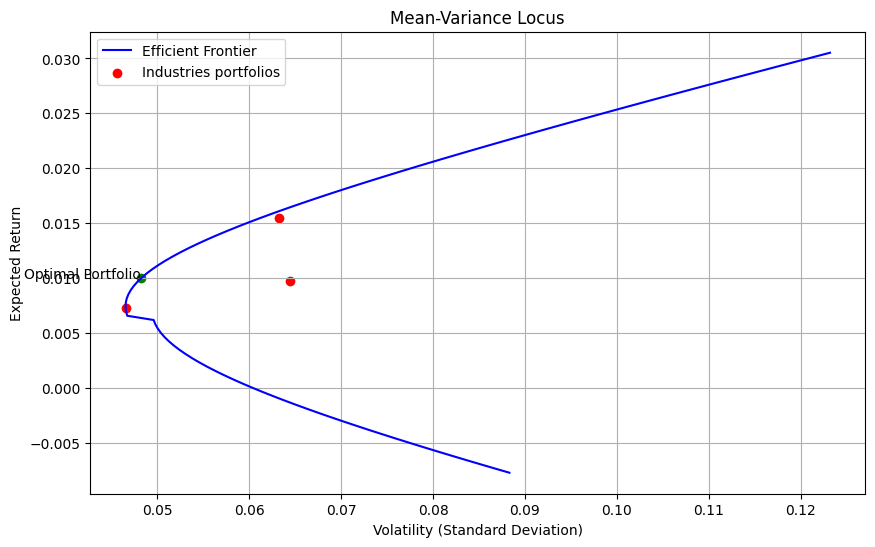

In [8]:
# Générer une série de rendements cibles
rendements_cibles = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 100) 

# Calcul des volatilités et des rendements pour la frontière efficiente
volatilites_optimales = []
rendements_optimaux = []
for R_cible in rendements_cibles:
    current_constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, Z_barre_sub) - R_cible}
    ]
    result = minimize(portfolio_variance, initial_weights, args=(Sigma_sub,), method='SLSQP', constraints=current_constraints)
    if result.success:
        rendement_optimal = np.dot(result.x, Z_barre_sub)
        volatilite_optimale = np.sqrt(result.fun)
        rendements_optimaux.append(rendement_optimal)
        volatilites_optimales.append(volatilite_optimale)

# Tracer la frontière efficiente
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales, rendements_optimaux, 'b-', label='Efficient Frontier')
plt.scatter(np.sqrt(np.diag(Sigma_sub)), Z_barre_sub, color='red', label='Industries portfolios')
# Tracer le portefeuille optimal

plt.title('Mean-Variance Locus')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)

# Calculer le rendement et la volatilité du portefeuille optimal selon la combinaison optimale de 3 actifs parmi 5 actifs disponibles 
rendement_optimal = np.dot(best_weights, Z_barre_sub)
volatilite_optimale = np.sqrt(np.dot(best_weights.T, np.dot(Sigma_sub, best_weights)))

# Tracer le portefeuille optimal
plt.scatter(volatilite_optimale, rendement_optimal, color='green', label='Optimal Portfolio')
plt.text(volatilite_optimale, rendement_optimal, 'Optimal Portfolio', ha='right')
plt.show()

In [9]:
# Variables de décision
weights = cp.Variable(N)  # Poids des actifs dans le portefeuille
selection = cp.Variable(N, boolean=True)  # Variables binaires pour la contrainte de cardinalité

# Fonction objectif
risk = cp.quad_form(weights, Sigma)  # Variance du portefeuille (risque)
objective = cp.Minimize(risk)

# Contraintes
constraints = [
    cp.sum(weights) == 1,  # La somme des poids doit être égale à 1
    weights >= min_weight * selection,  # Poids minimum pour les actifs sélectionnés
    cp.sum(selection) <= max_num_assets,  # Cardinalité: au maximum 3 actifs dans le portefeuille
    cp.sum(weights @ Z_barre) >= R_cible_basse,  # Rendement attendu du portefeuille supérieur ou égal à R_cible_basse
    cp.sum(weights @ Z_barre) <= R_cible_haute  # Rendement attendu du portefeuille inférieur ou égal à R_cible_haute
]

# Résolution du problème
prob = cp.Problem(objective, constraints)
prob.solve()  # Utilisez un solveur capable de gérer les variables binaires

# Vérifier si le problème a été résolu correctement
if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
    optimal_weights = weights.value
    global_min_variance = risk.value  # Variance minimale du portefeuille
    print("Poids optimaux du portefeuille :", optimal_weights)
    print("Variance minimale globale du portefeuille :", global_min_variance)

Restricted license - for non-production use only - expires 2025-11-24
Poids optimaux du portefeuille : [4.41818999e-10 2.49617559e-07 3.29149182e-01 6.70850567e-01
 1.95686440e-10]
Variance minimale globale du portefeuille : 0.002349198913995824


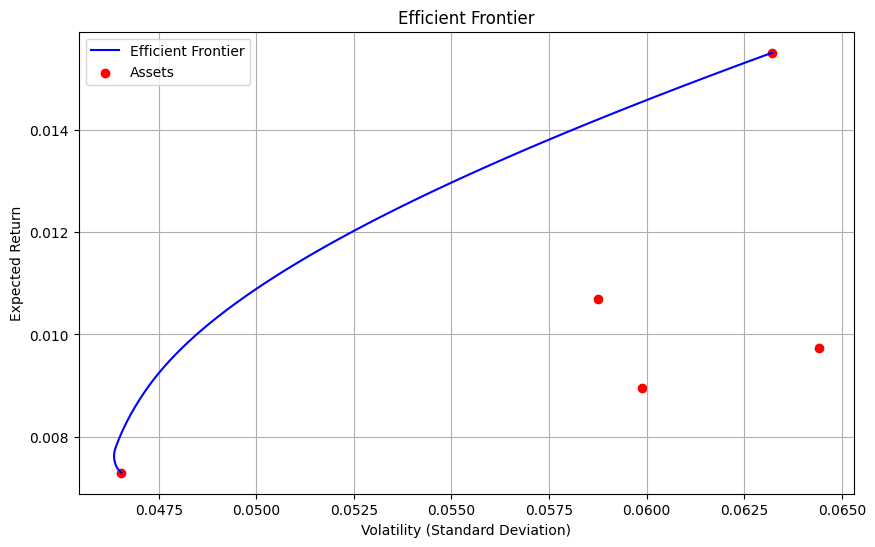

In [10]:
# Générer une série de rendements cibles
rendements_cibles = np.linspace(min(Z_barre), max(Z_barre), 100)

# Variables de décision
weights = cp.Variable(N)  # Poids des actifs dans le portefeuille
selection = cp.Variable(N, boolean=True)  # Variables binaires pour la contrainte de cardinalité

# Fonction objectif
risk = cp.quad_form(weights, Sigma)  # Variance du portefeuille (risque)
objective = cp.Minimize(risk)

# Contraintes de base
base_constraints = [
    cp.sum(weights) == 1,  # La somme des poids doit être égale à 1
    weights >= min_weight * selection,  # Poids minimum pour les actifs sélectionnés
    cp.sum(selection) <= max_num_assets  # Cardinalité: au maximum 3 actifs dans le portefeuille
]

# Calcul des volatilités et des rendements pour la frontière efficiente
volatilites_optimales = []
rendements_optimaux = []
for R_cible in rendements_cibles:
    # Ajouter la contrainte de rendement pour le rendement cible actuel
    constraints = base_constraints + [
        cp.sum(weights @ Z_barre) == R_cible  # Rendement attendu du portefeuille égal à R_cible
    ]
    
    # Résolution du problème
    prob = cp.Problem(objective, constraints)
    prob.solve()  # Utilisez un solveur capable de gérer les variables binaires
    
    # Vérifier si le problème a été résolu correctement
    if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        rendement_optimal = np.dot(weights.value, Z_barre)
        volatilite_optimale = np.sqrt(risk.value)
        rendements_optimaux.append(rendement_optimal)
        volatilites_optimales.append(volatilite_optimale)

# Tracer la frontière efficiente
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales, rendements_optimaux, 'b-', label='Efficient Frontier')
plt.scatter(np.sqrt(np.diag(Sigma)), Z_barre, color='red', label='Assets')

plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()